# **Initial Data Exploration**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv("My Victim List - Compiled.csv")

# 2. Missing Value Analysis
# We need to count both standard NaNs and text "na"
missing_counts = {}
for col in df.columns:
    nan_count = df[col].isnull().sum()
    # Check for "na" string if column is text
    if df[col].dtype == 'object':
        na_str_count = df[col].astype(str).str.strip().str.lower().eq('na').sum()
    else:
        na_str_count = 0
    missing_counts[col] = nan_count + na_str_count

df.head(5)


,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Longtitude,Latitude,Post URL
0,NaN,41,Male,01/24/2020,5:12 PM,01/16/2021,"Sampaloc, Manila",NaN,NaN,https://www.facebook.com/share/p/1CwZW3pbpf/
1,NaN,14,Male,2/15/2020,12:19 PM,na,"Binondo, Manila",NaN,NaN,https://www.facebook.com/share/p/17Umn23xj9/
2,NaN,23,Male,08/11/2020,11:03 PM,na,Pasig City,NaN,NaN,https://www.facebook.com/share/p/1GXZbwDo5X/
3,NaN,78,Male,9/10/2020,11:01 PM,na,Pasay City,NaN,NaN,https://www.facebook.com/share/17jCD4k7YL/
4,NaN,21,Male,10/11/2020,7:55 AM,na,Quezon City,NaN,NaN,https://www.facebook.com/share/p/1Bcegb6eYd/


Total Dataset Empty: 35.24%
Missing Counts per Column: {'Person ID': np.int64(187), 'AGE': np.int64(0), 'GENDER': np.int64(0), 'Date Reported Missing': np.int64(1), 'Time Reported Missing': np.int64(13), 'Date Last Seen': np.int64(83), 'Location Last Seen': np.int64(2), 'Longtitude': np.int64(186), 'Latitude': np.int64(187), 'Post URL': np.int64(0)}


/tmp/ipython-input-1183053842.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')


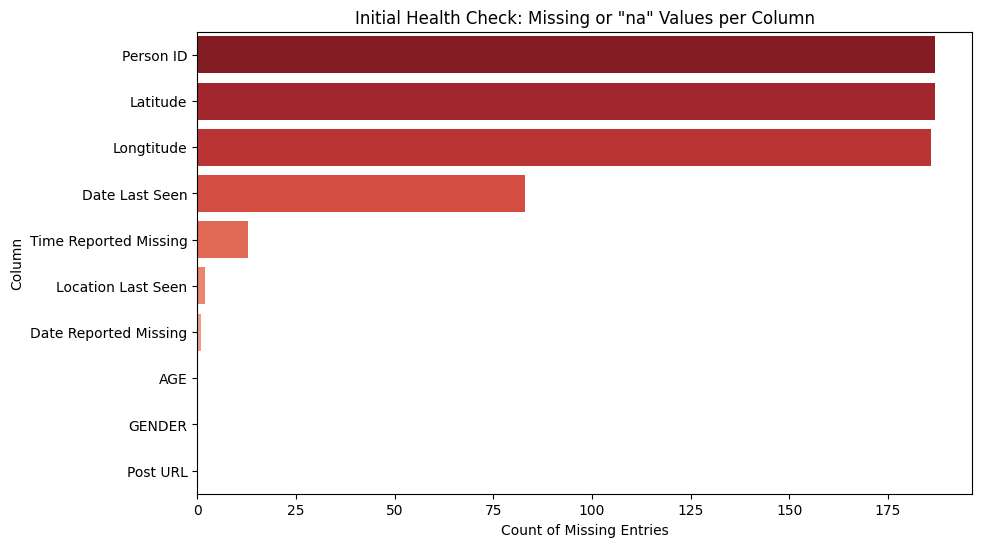

In [2]:
# Calculate total percentage empty
total_cells = df.size
total_missing = sum(missing_counts.values())
percent_empty = (total_missing / total_cells) * 100

print(f"Total Dataset Empty: {percent_empty:.2f}%")
print("Missing Counts per Column:", missing_counts)

# 3. Visualization
missing_df = pd.DataFrame(list(missing_counts.items()), columns=['Column', 'Missing Count'])
missing_df = missing_df.sort_values(by='Missing Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')
plt.title('Initial Health Check: Missing or "na" Values per Column')
plt.xlabel('Count of Missing Entries')
plt.show()

## **Data Preprocessing**

In [3]:
# 1. Drop Irrelevant Columns
df_clean = df.drop(columns=['Latitude', 'Longtitude'])

In [4]:
# 2. Standardize Demographics
# Clean Gender (remove spaces, capitalize)
df_clean['GENDER'] = df_clean['GENDER'].str.strip().str.capitalize()

In [5]:
# 3. Parse Dates & Times
# Convert Date columns
df_clean['Date Reported Missing'] = pd.to_datetime(df_clean['Date Reported Missing'], errors='coerce')

In [6]:
# Handle 'na' in Date Last Seen before converting
df_clean['Date Last Seen'] = df_clean['Date Last Seen'].replace('na', pd.NA)
df_clean['Date Last Seen'] = pd.to_datetime(df_clean['Date Last Seen'], errors='coerce')

# Clean Time: Handle 'na' and convert mixed formats (12h/24h)
df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
# The datetime converter infers the correct format automatically
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')

/tmp/ipython-input-1347800615.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [7]:
df_clean.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj
0,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-10 17:12:00
1,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-10 12:19:00
2,NaN,23,Male,2020-08-11,11:03 PM,NaT,Pasig City,https://www.facebook.com/share/p/1GXZbwDo5X/,2025-12-10 23:03:00
3,NaN,78,Male,2020-09-10,11:01 PM,NaT,Pasay City,https://www.facebook.com/share/17jCD4k7YL/,2025-12-10 23:01:00
4,NaN,21,Male,2020-10-11,7:55 AM,NaT,Quezon City,https://www.facebook.com/share/p/1Bcegb6eYd/,2025-12-10 07:55:00


## **Age Binning**

In [8]:
def smart_bin_age(val):
    s_val = str(val).lower().strip()
    if s_val == 'adult': return 'Adult'
    elif s_val in ['senior', 'adult older']: return 'Old'
    elif s_val == 'teen': return 'Teen'
    elif s_val == 'young teen': return 'Young Teen'
    elif s_val == 'young adult': return 'Young Adult'
    elif s_val == 'child': return 'Child'

    try:
        age_num = float(val)
        if pd.isna(age_num): return "Unknown"
        if age_num < 13: return "Child"
        elif 13 <= age_num <= 14: return "Young Teen"
        elif 15 <= age_num <= 17: return "Teen"
        elif 18 <= age_num <= 24: return "Young Adult"
        elif 25 <= age_num <= 59: return "Adult"
        else: return "Old"
    except:
        return "Unknown"

/tmp/ipython-input-4055080421.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')


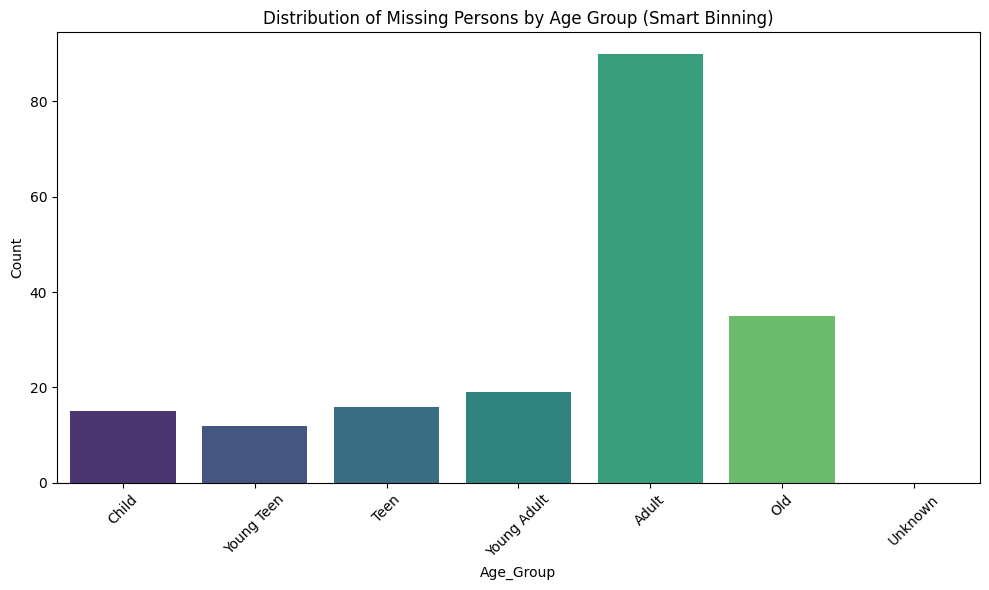

In [9]:
# Apply Logic
df_clean['Age_Group'] = df_clean['AGE'].apply(smart_bin_age)

# Plotting
plt.figure(figsize=(10, 6))
order = ["Child", "Young Teen", "Teen", "Young Adult", "Adult", "Old", "Unknown"]
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group (Smart Binning)')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## **City - Baranggay Segregation**

In [10]:
mm_cities_list = [
    "manila", "quezon", "caloocan", "las piñas", "las pinas", "makati",
    "malabon", "mandaluyong", "marikina", "muntinlupa", "navotas",
    "parañaque", "paranaque", "pasay", "pasig", "pateros", "san juan",
    "taguig", "valenzuela", "antipolo"
]

def parse_location(loc):
    if pd.isna(loc) or str(loc).lower() == 'na': return "Unknown"

    loc_str = str(loc)
    # Cleanup: normalize case and remove 'city' for matching
    loc_clean = loc_str.lower().replace("city", "").replace(".", "")

    # Match against known list
    found_city = "Other/Unknown"
    for city in mm_cities_list:
        if city in loc_clean:
            # Handle spelling variations
            if city == "las pinas": found_city = "Las Piñas"
            elif city == "paranaque": found_city = "Parañaque"
            else: found_city = city.title()
            break

    return found_city

df_clean['City_Cleaned'] = df_clean['Location Last Seen'].apply(parse_location)

# 3. Clean Date & Time
df_clean['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
df_clean['Year'] = df_clean['Date Reported Missing'].dt.year

df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')
df_clean['Hour_Missing'] = df_clean['Time_Obj'].dt.hour

df_clean.to_csv("DMResearch - Missing People.csv", index=False)

/tmp/ipython-input-2124726120.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [18]:
df_clean.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Year,Hour_Missing
0,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-10 17:12:00,Adult,Manila,2020.0,17.0
1,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-10 12:19:00,Young Teen,Manila,2020.0,12.0
2,NaN,23,Male,2020-08-11,11:03 PM,NaT,Pasig City,https://www.facebook.com/share/p/1GXZbwDo5X/,2025-12-10 23:03:00,Young Adult,Pasig,2020.0,23.0
3,NaN,78,Male,2020-09-10,11:01 PM,NaT,Pasay City,https://www.facebook.com/share/17jCD4k7YL/,2025-12-10 23:01:00,Old,Pasay,2020.0,23.0
4,NaN,21,Male,2020-10-11,7:55 AM,NaT,Quezon City,https://www.facebook.com/share/p/1Bcegb6eYd/,2025-12-10 07:55:00,Young Adult,Quezon,2020.0,7.0


## **Exploratory Data Analysis**

/tmp/ipython-input-3389320361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')


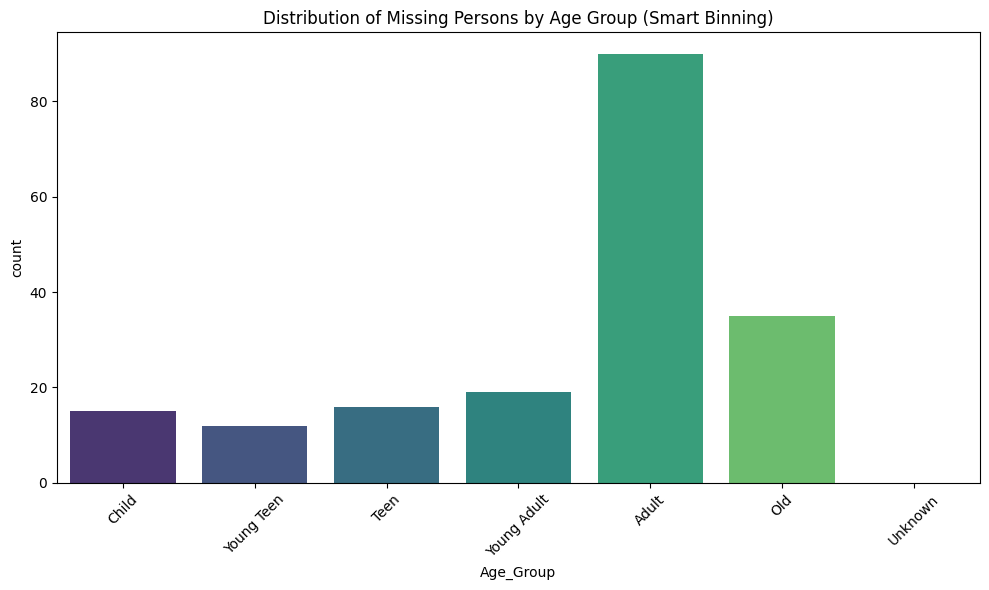

In [19]:
# Chart 1: Demographics (Smart Binning)
plt.figure(figsize=(10, 6))
order = ["Child", "Young Teen", "Teen", "Young Adult", "Adult", "Old", "Unknown"]
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group (Smart Binning)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

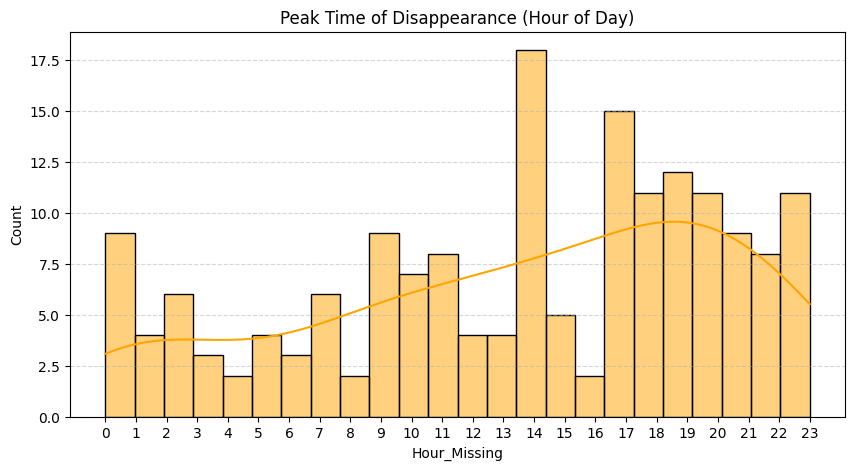

In [21]:
# 3. Temporal: Peak Time
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='Hour_Missing', bins=24, kde=True, color='orange')
plt.title('Peak Time of Disappearance (Hour of Day)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

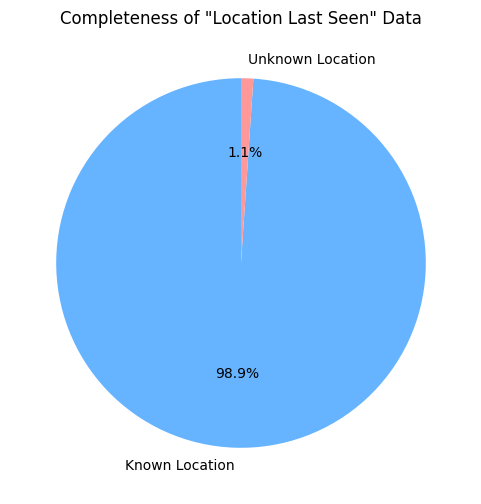

In [22]:
# 4. Data Completeness: Location Check
missing_loc_count = df_clean['Location Last Seen'].isnull().sum() + \
                    (df_clean['Location Last Seen'].astype(str).str.lower() == 'na').sum()
present_loc_count = len(df_clean) - missing_loc_count

plt.figure(figsize=(6, 6))
plt.pie([present_loc_count, missing_loc_count], labels=['Known Location', 'Unknown Location'],
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Completeness of "Location Last Seen" Data')
plt.show()

## **Rose Diagram**

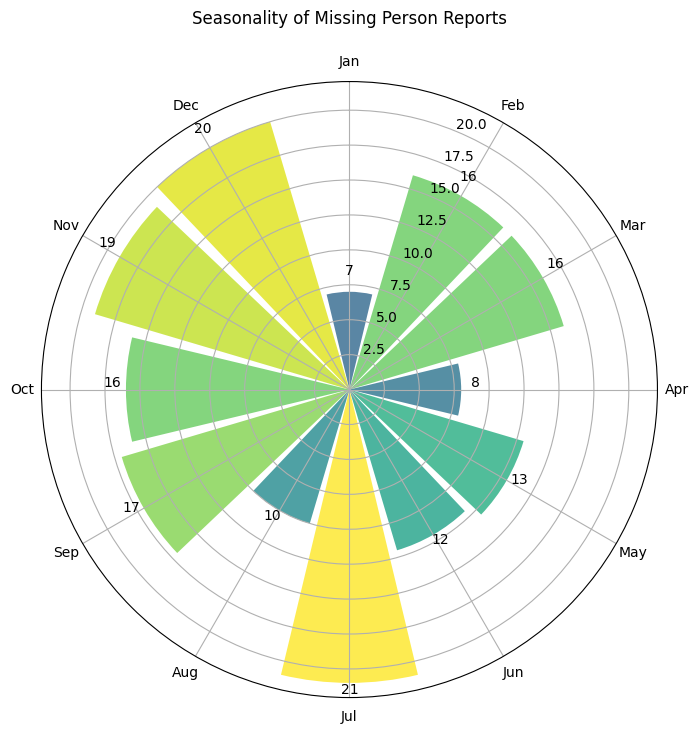

In [26]:
import numpy as np

# The 'Date Reported Missing' column in df_clean is already in datetime format from previous steps.
# We will use df_clean directly to ensure consistency.
df_dates = df_clean.dropna(subset=['Date Reported Missing']).copy()
df_dates['Month'] = df_dates['Date Reported Missing'].dt.month

# 2. Aggregation
# Count reports per month and ensure all 12 months are represented
monthly_counts = df_dates['Month'].value_counts().sort_index()
# Fill missing months with 0
for m in range(1, 13):
    if m not in monthly_counts:
        monthly_counts[m] = 0
monthly_counts = monthly_counts.sort_index()

# 3. Plotting the Rose Diagram
# Setup angles and bar width
theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
width = (2 * np.pi) / 12 * 0.9

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Configure: 0 degrees at Top (North), Clockwise direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Draw bars
bars = ax.bar(theta, monthly_counts.values, width=width, bottom=0.0, alpha=0.8,
              color=plt.cm.viridis(monthly_counts.values / max(monthly_counts.values)))

# Add labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(theta)
ax.set_xticklabels(month_labels)

# Add numeric counts
for bar, angle, count in zip(bars, theta, monthly_counts.values):
    ax.text(angle, bar.get_height() + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.title("Seasonality of Missing Person Reports", y=1.08)
plt.show()

## **Time Series Chart**

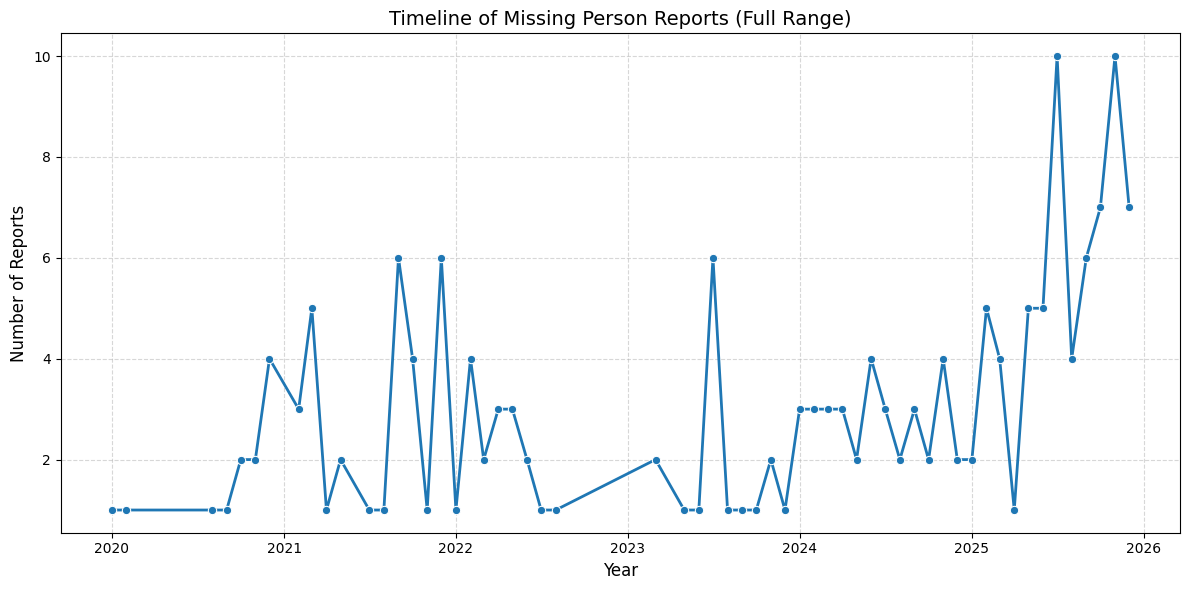

In [29]:
import matplotlib.dates as mdates

# Use all date entries from df_clean
df_ts = df_clean.copy()

# 2. Aggregation (Monthly)
# Group by Month to see the trend over time
monthly_counts = df_ts.groupby(df_ts['Date Reported Missing'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

# 3. Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', color='#1f77b4', linewidth=2)

plt.title('Timeline of Missing Person Reports (Full Range)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reports', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Format X-Axis to show years clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

manila only

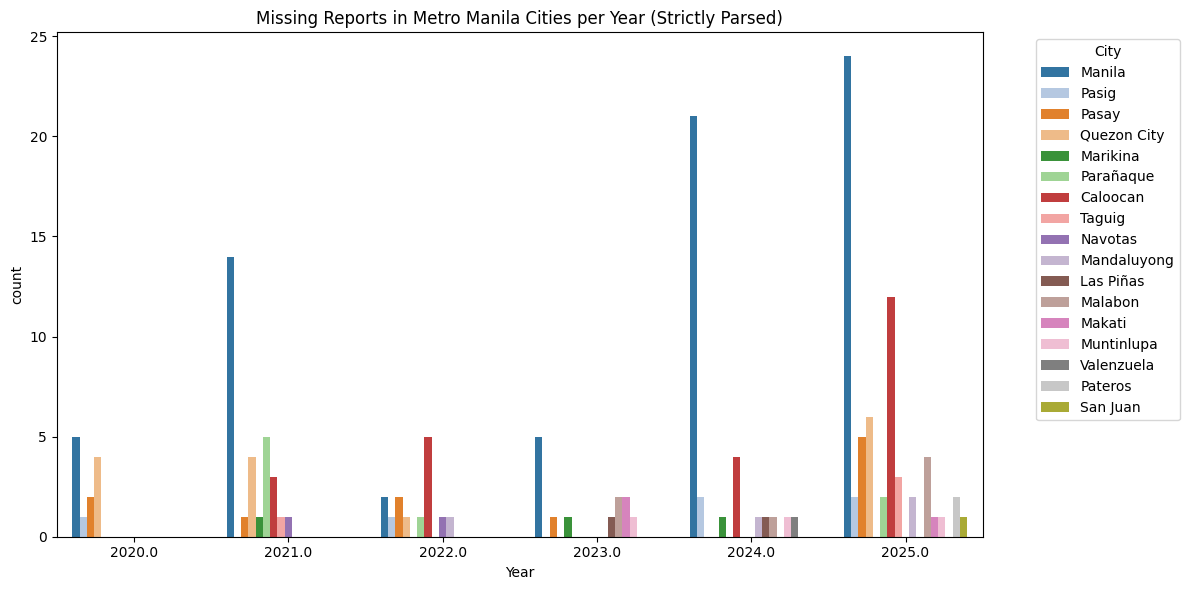

Total number of cases from 2020-2025: 175


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("My Victim List - Compiled.csv")

# Preprocessing
df['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
df['Year'] = df['Date Reported Missing'].dt.year

# Strict Parsing Function
def get_strict_city_for_plot(loc):
    if pd.isna(loc) or str(loc).lower() == 'na': return "Other/Unknown"
    loc_clean = str(loc).lower().replace('.', '').strip()

    # Map for canonical names
    other_cities = {
        "quezon": "Quezon City", "caloocan": "Caloocan", "las pinas": "Las Piñas",
        "las piñas": "Las Piñas", "makati": "Makati", "malabon": "Malabon",
        "mandaluyong": "Mandaluyong", "marikina": "Marikina", "muntinlupa": "Muntinlupa",
        "navotas": "Navotas", "parañaque": "Parañaque", "paranaque": "Parañaque",
        "pasay": "Pasay", "pasig": "Pasig", "pateros": "Pateros", "san juan": "San Juan",
        "taguig": "Taguig", "valenzuela": "Valenzuela"
    }

    # 1. Check Specific Cities First
    for key, val in other_cities.items():
        if key in loc_clean:
            # Exclude street names
            if key == 'quezon' and ('quezon blvd' in loc_clean or 'quezon ave' in loc_clean): continue
            if key == 'san juan' and 'san juan st' in loc_clean: continue
            return val

    # 2. Check Strict Manila
    if 'manila' in loc_clean:
        # Remove 'metro manila' to see if 'manila' remains
        temp_str = loc_clean.replace("metro manila", "").replace("ncr", "")
        if 'manila' in temp_str:
            return "Manila"

    return "Other/Unknown"

# Apply
df['City_Cleaned'] = df['Location Last Seen'].apply(get_strict_city_for_plot)
df_mm = df[df['City_Cleaned'] != "Other/Unknown"]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_mm, x='Year', hue='City_Cleaned', palette='tab20')
plt.title('Missing Reports in Metro Manila Cities per Year (Strictly Parsed)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='City')
plt.tight_layout()
plt.show()

# Count total cases from 2020-2025
cases_2020_2025 = df[(df['Year'] >= 2020) & (df['Year'] <= 2025)].shape[0]
print(f"Total number of cases from 2020-2025: {cases_2020_2025}")